<a href="https://colab.research.google.com/github/MihirKT/upskillcampus/blob/main/Crop%26WeedDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imoporting Libraries**

In [3]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, f1_score

# **Loading and downloading the data**

In [4]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'crop-and-weed-detection-data-with-bounding-boxes:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F589173%2F1062313%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240611%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240611T124752Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D94291979aac6737c1ff8dc3034e5a91f749a772c09e85d9f76eb785052225f3ab17ffdf6f5cbfc31b782d355004ba107232a72475d253196695bff3bcb1853b907598fc4b17e1b872557f05661f77d2c1884f4ec8387ebd6c32d9b1aad690c4ceecdc52d84ccbbd71df9c6f40957b4a63b449141b49ae9538220081387d51291ece733cb091c85479535508755ccad11f2373e355f8f138fee839142f594e3d1e9f33edb8d6e061d5fbc42676c7663310fe81057d73a09eea1b747c00ea757bffc2aba23bd75a683fafa195fafb27c5740a919aa4077e06f296ccaf60f7a1fc0cec1809e70c4e4ccdf02c32ea085027af77e5f482a7d2032734264fed344ff36'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 83008512 bytes downloaded
Downloaded and uncompressed: crop-and-weed-detection-data-with-bounding-boxes
Data source import complete.


# Converting text file into dataframe

In [5]:
path = '/kaggle/input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/'
data = [os.path.join(path, x) for x in os.listdir(path)]
images = [x for x in data if x.endswith('.jpeg')]
labels = [x for x in data if x.endswith('.txt')]

# **Display a Sample image**

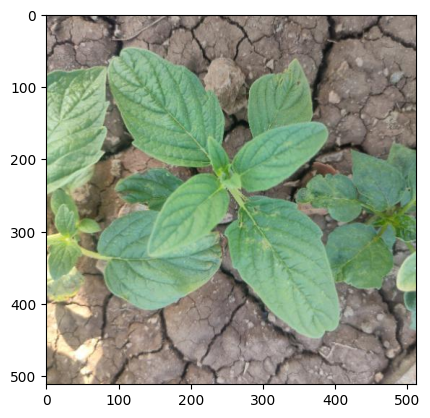

In [6]:
plt.imshow(cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2RGB))
plt.show()

# **Creating a dataframe from the labels**

In [9]:
df_list = []
for img_path in tqdm(images):
    label_path = img_path[:-5] + '.txt'
    with open(label_path, 'r') as file:
        labels = file.read().strip().split('\n')

    for label in labels:
        obj_id, x_cen, y_cen, w, h = map(float, label.split())
        df_list.append({
            'image_name': img_path[len(path):],
            'object': int(obj_id),
            'x_cen': x_cen,
            'y_cen': y_cen,
            'w': w,
            'h': h
        })

df = pd.DataFrame(df_list)
print(df.head())

100%|██████████| 1300/1300 [00:00<00:00, 13264.07it/s]

         image_name  object     x_cen     y_cen         w         h
0   agri_0_603.jpeg       0  0.500977  0.463867  0.998047  0.783203
1  agri_0_7878.jpeg       0  0.498047  0.500977  0.929688  0.888672
2  agri_0_5121.jpeg       0  0.402344  0.548828  0.800781  0.750000
3  agri_0_5121.jpeg       0  0.671875  0.265625  0.656250  0.523438
4  agri_0_7322.jpeg       0  0.505859  0.506836  0.843750  0.814453


# Converting dataframe into Pascal-voc format

In [10]:
column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
pascal_voc = pd.DataFrame(columns=column_name)

for i in tqdm(range(len(df))):
    pascal_voc.loc[i, 'filename'] = df.loc[i, 'image_name']
    pascal_voc.loc[i, 'width'] = 512
    pascal_voc.loc[i, 'height'] = 512
    pascal_voc.loc[i, 'class'] = 'crop' if df.loc[i, 'object'] == 0 else 'weed'
    pascal_voc.loc[i, 'xmin'] = int((df.loc[i, 'x_cen'] - df.loc[i, 'w'] / 2) * 512)
    pascal_voc.loc[i, 'ymin'] = int((df.loc[i, 'y_cen'] - df.loc[i, 'h'] / 2) * 512)
    pascal_voc.loc[i, 'xmax'] = int((df.loc[i, 'x_cen'] + df.loc[i, 'w'] / 2) * 512)
    pascal_voc.loc[i, 'ymax'] = int((df.loc[i, 'y_cen'] + df.loc[i, 'h'] / 2) * 512)

print(pascal_voc.head())

100%|██████████| 2072/2072 [00:01<00:00, 1041.88it/s]

           filename width height class xmin ymin xmax ymax
0   agri_0_603.jpeg   512    512  crop    1   36  512  437
1  agri_0_7878.jpeg   512    512  crop   16   29  493  484
2  agri_0_5121.jpeg   512    512  crop    1   88  411  472
3  agri_0_5121.jpeg   512    512  crop  176    1  512  270
4  agri_0_7322.jpeg   512    512  crop   42   51  474  468


# Visualizing labels

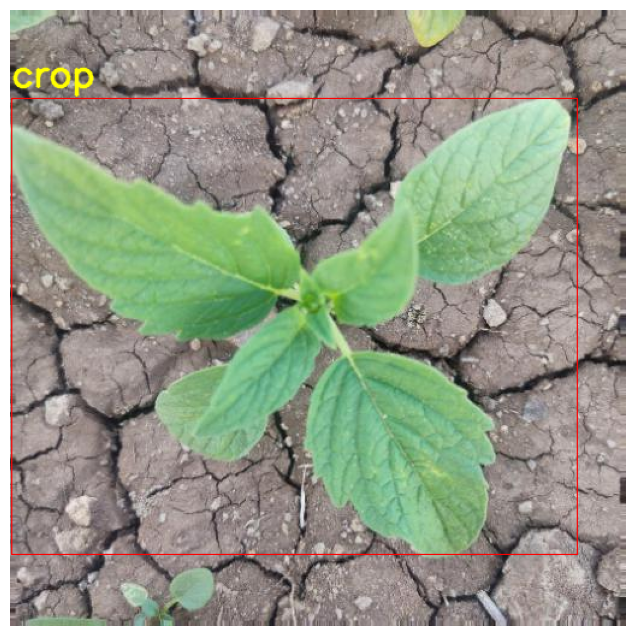

In [11]:
any_index_number = 90  # Change this number for different images
test_img = cv2.cvtColor(cv2.imread(path + pascal_voc.loc[any_index_number, 'filename']), cv2.COLOR_BGR2RGB)
test_df = pascal_voc[pascal_voc['filename'] == pascal_voc.loc[any_index_number, 'filename']].reset_index(drop=True)

for i in range(len(test_df)):
    cv2.rectangle(test_img, (test_df.loc[i, 'xmin'], test_df.loc[i, 'ymin']),
                  (test_df.loc[i, 'xmax'], test_df.loc[i, 'ymax']), (255, 0, 0), 1)
    cv2.putText(test_img, test_df.loc[i, 'class'], (test_df.loc[i, 'xmin'], test_df.loc[i, 'ymin'] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize=(8, 8))
plt.imshow(test_img)
plt.axis('off')
plt.show()

# Saving label file

In [12]:
pascal_voc.to_csv('pascal_voc_format.csv', index=False)